# Recommender System For Dating Agency

# Introduction

Users of online dating sites are facing information overload that requires them to manually construct queries and browse huge amount of matching user profiles. A typical dating site requires users to fill in lengthy questionnaires and matching is based on attributes selected. The search in the database either returns no match in the case when the query is too specific or, for general queries, returns a huge amount of profiles. In the end users end up browsing large amount of irrelevant results. Building a recommender system can help to improve user experience of dating site users and lead to a higher user satisfaction by making the process of finding a relevant candidate quicker and more efficient.

The purpose of this project is to develop a recommender system using collaborative filtering algorithms (user- and item-based) walking though the following steps:

1. Data Exploration
2. User-Based Collaborative Filtering (top N recommendations)
3. Item-Based Collaborative Filtering (top N recommendations)
4. KNN Recommender Algorithms. Selecting the best system based on the RMSE using cross validation.
5. Measuring Coverage and Diversity of the selected KNN-Recommender Algorithm.
6. Implementation SVD method and tuning it selecting best parameter using RMSE.

Core ML package that will be used throughout the project is Surprise - Python scikit building and analyzing recommender systems library.

Data Source: http://www.occamslab.com/petricek/data/

This data set contains 168,791 profiles and presented in the following format:

UserID is user who provided rating

ProfileID is user who has been rated

UserIDs range between 1 and 135,359

ProfileIDs range between 1 and 220,970 (not every profile has been rated)

Ratings are on a 1-10 scale where 10 is best (integer ratings only)

# Data Preparation 

In [11]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
from operator import itemgetter
from surprise.model_selection import GridSearchCV
from surprise import KNNBaseline, KNNWithZScore, NormalPredictor, KNNWithMeans, BaselineOnly, SVD, KNNBasic, SlopeOne, NMF, CoClustering

# import heapq
import random 
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [41]:
# reading file into a pandas data frame from the source. File is to big to push it to GitHub, even zip version
data = pd.read_csv("https://raw.githubusercontent.com/olgashiligin/DATA_612/master/final%20project/ratings_1000.csv", header=None)
data.columns = ["userID", "candidateID", "rating"]
data.head()

,userID,candidateID,rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [14]:
#  rating distribution
data.rating.value_counts().sort_index(ascending=False)

10    28885
9      9459
8     13771
7     14890
6     13133
5     16786
4      9502
3      8583
2     10787
1     20752
Name: rating, dtype: int64

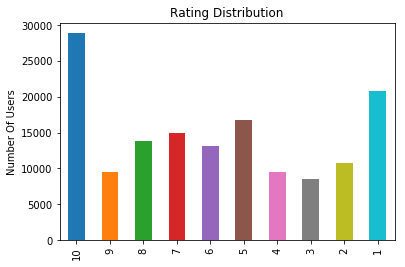

In [15]:
# rating distribution (graph)
data.rating.value_counts().sort_index(ascending=False).plot(kind='bar')
plt.title('Rating Distribution')
plt.ylabel('Number Of Users')
plt.show()

10 is the most popular rating. 1 and 5 are also polular ratings.

In [16]:
# number of ratings per each candidate
data.groupby('candidateID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,candidateID,rating
33899,156148,240
6711,31116,218
26648,121859,182
41569,193687,169
18350,83773,159
19668,89855,151
15666,71636,148
4743,22319,140
4410,20737,138
7166,33216,138


# User-Based and Item-Based (top N recommendations)

The first algorithm that will be built is user-based collaborative filtering. I will take the "test user" (for example,10th user) and find the top 10 candidates for the "test user" via following steps:

1. Candidate generation step when we pull all the candidates in from every neighbor of the selected "test user". Neighbours for the "test user" is selected based on the similarity measure.

2. Candidate scoring allows to select the best candidates for the "test user". I will weigh ratings by users similarity.

3. Sorting the candidates by their final score.

4. Candidates filtering where I filter out candidates which the "test user" has already rated. Also I will apply filter on the min candidate score or min similarity.

In [53]:
# reading csv file
reader = Reader(sep=',', rating_scale=(1, 10))
data = Dataset.load_from_file("/Users/Olga/PycharmProjects/rec_sys_final/ratings_1000.csv", reader=reader)
# splitting data set on train and test
trainSet, testSet = train_test_split(data, test_size=0.2)

In [19]:
#  assigning similarity measure options
sim_options = {'name': 'cosine', 'user_based': True}

#  computing user to user similarity matrix using KNNBasic algorithm
model = KNNBasic(sim_options = sim_options)
model.fit(trainSet)
simMatrix = model.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [20]:
# selecting test user - for example, 10th user
testUser = '10'

# extracting similar users to our test user
testUserInnerID = trainSet.to_inner_uid(testUser)
similarityRow = simMatrix[testUserInnerID]

# converting these users to the list of tuples containing inner user Id and similarity score (skipping the test user similarity to him/herself)
similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append( (innerID, score) )
        
#  filtering out users with similarity score to the test user less than 0.95   
kNeighbors = []
for rating in similarUsers:
    if rating[1] > 0.95:
        kNeighbors.append(rating)

# getting the candidates the users have rated, and adding up ratings for each candidate, weighted by user similarity
candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainSet.ur[innerID]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1]/10.0) * userSimilarityScore

# Building a dictionary of candidates that the test user has already rated
rated = {}
for candidateID, rating in trainSet.ur[testUserInnerID]:
    rated[candidateID] = 1

# getting 10 top-rated candidates for the test user:
n = 10
pos = 1
# sorting the candidates by the final score and selecting top 10 skipping the results that the test user has already rated.
for candidateID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not candidateID in rated:
        candidateID = trainSet.to_raw_iid(candidateID)
#       printing candidates IDs for 10th test user 
        print(candidateID, ratingSum)
        pos += 1
        if (pos > n):
            break

33216 45.154194077439186
22319 38.02369596596644
113157 36.86256298243028
71570 28.898251052139255
81470 24.77152711555244
97992 18.711020415926267
22327 18.6
73728 17.21974592397711
74257 17.116045795877078
25978 16.44537607994736


 Next algorithm that I am going to implement is item-based. I will take the same "test user" (10th user) and find the top 10 candidates for the "test user" using item-based collaborative filtering.
Item similarities can be better then similarities between users because items tend to have more permanent nature, unlike users' tastes. That's why focusing on the similarities between unchanging objects may produce better results.
The algorithms for item-based recommendations is quite similar to user - based, we are just focusing on the relations between items instead of users.

In [21]:
#  assigning similarity measure options
sim_options = {'name': 'cosine',
               'user_based': False
               }

#  computing candidate to candidate similarity matrix 
model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simsMatrix = model.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
# selecting test user - for example, 10th user
testUser = '10'

# converting a user raw id to an inner id
testUserInnerID = trainSet.to_inner_uid(testUser)
# extracting similar candidates to the candidates the test user prefer
testUserRatings = trainSet.ur[testUserInnerID]

# filtering out candidates with rating less then 8
kNeighbors = []
for rating in testUserRatings:
    if rating[1] > 8.0:
        kNeighbors.append(rating)
        

# getting the candidates and adding up ratings for each candidate, weighted by similarity score
candidates = defaultdict(float)
for candidateID, rating in kNeighbors:
    similarityRow = simsMatrix[candidateID]
    for innerID, score in enumerate(similarityRow):
        candidates[innerID] += score * (rating)/10.0
    
# building a dictionary of candidates that the test user has already seen
rated = {}
for candidateID, rating in trainSet.ur[testUserInnerID]:
    rated[candidateID] = 1
    
# getting 10 top-rated candidated for the test user:
n = 10
pos = 1
for candidateID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not candidateID in rated:
        candidateID = trainSet.to_raw_iid(candidateID)
        print(candidateID, ratingSum)
        pos += 1
        if (pos > n):
            break

    

113666 2.8
110424 2.8
109899 2.8
200492 2.798446935857496
9652 2.788986668796162
77036 2.773687418864638
71570 2.771559411588529
22319 2.756795134263671
125439 2.7461785443066185
82986 2.7405691595989397


User-based and item-based algorithms produced quite different recommendations: only 2 out of 10 recommendations are similar for the 10th user. It is hard to tell if they are good or bad. I can not measure accuracy for the simple ser-/item-based algorithms produced above as they are not rating prediction methods which I will consider further.

# KNN Recommender Algorithms

The concept of collaborative filtering has been applied to recommender systems that make rating predictions and this is called KNN recommenders.
In KNN recommender systems we are generating recommendation candidates by predicting their rating and selecting top K candidates with the highest predicted rating. Since we are using ratings prediction we can measure system accuracy via train/test split or cross-validation. 

KNN recommenders are not just recommending candidates that people similar to the selected user like, but also they are trying to predict rating for every possible candidate for every possible user. 

The following basics algorithms will be benchmarked in order to select the best one:

    - NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.
    - KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.
    - KNNBasic is a basic collaborative filtering algorithm.
    - KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
    - KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
    - BaselineOnly is a basic collaborative filtering algorithm taking into account a baseline rating.
    - SVD is a method that utilizes matrix factorization technique.
    
Some of these algorithms use baseline estimates, some use a similarity measures.  
These algorithms will be tested using user- and item-based approach with cosine or pearson similarity measure. Cross-validation will be applied to measure algorithms accuracy via RMSE.

In [23]:
benchmark = []
sim_options = {'name': 'cosine', 'user_based': True}
# iterating over all algorithms
for algorithm in [SVD(), NormalPredictor(), KNNBaseline(sim_options=sim_options), KNNBasic(sim_options=sim_options), KNNWithMeans(sim_options=sim_options), KNNWithZScore(sim_options=sim_options), BaselineOnly()]:
    # performing 3 fold cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # getting results & appending algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity mat

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,2.374041,0.616729,1.436186
KNNWithMeans,2.465770,0.276004,1.066208
KNNWithZScore,2.475599,0.339966,1.224553
SVD,2.480321,6.246900,0.488930
BaselineOnly,2.521116,0.369429,0.328299
KNNBasic,2.582169,0.247367,1.111087
NormalPredictor,4.131257,0.156038,0.369851


In [24]:
benchmark = []
sim_options = {'name': 'pearson', 'user_based': True}
# iterating over all algorithms
for algorithm in [SVD(), NormalPredictor(), KNNBaseline(sim_options=sim_options), KNNBasic(sim_options=sim_options), KNNWithMeans(sim_options=sim_options), KNNWithZScore(sim_options=sim_options), BaselineOnly()]:
    # performing 3 fold cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # getting results & appending algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing si

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,2.390775,0.676031,1.224962
SVD,2.482256,6.440402,0.498487
KNNWithZScore,2.487862,0.439788,1.259079
KNNWithMeans,2.489275,0.368903,1.107933
BaselineOnly,2.521466,0.392932,0.339808
KNNBasic,2.600046,0.329244,1.081094
NormalPredictor,4.139537,0.161848,0.412155


The most accurate result produces KNNBaseline, the worst - NormalPredictor, although it is the fastest algorithm. I am going to train and predict with KNNBaseline method.

In [27]:
#  splitting data on train and test set
trainSet, testSet = train_test_split(data, test_size=.15)
# selecting similarity options which gave the best result during cross-validation: user-based and pearson.
sim_options = {'name': 'pearson', 'user_based': True}
#  building the model
algo = KNNBaseline(sim_options = sim_options)
model = algo.fit(trainSet)
#  making predictions
predictions = model.test(testSet)
# calculating RMSE
accuracy.rmse(predictions)


Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.3180


2.318025404185668

In [28]:
# source: https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb
# selecting top 10 best and worst predictions.
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainSet.ur[trainSet.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainSet
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainSet.ir[trainSet.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [29]:
print(best_predictions)

       uid     iid   rui   est                                    details  \
21982  712  214534   1.0   1.0   {'actual_k': 1, 'was_impossible': False}   
11551  572   30031   1.0   1.0  {'actual_k': 10, 'was_impossible': False}   
11583  348  144691   1.0   1.0   {'actual_k': 6, 'was_impossible': False}   
11584   31   79138  10.0  10.0   {'actual_k': 7, 'was_impossible': False}   
11588  956    9759  10.0  10.0  {'actual_k': 13, 'was_impossible': False}   
11593  284   83846  10.0  10.0  {'actual_k': 14, 'was_impossible': False}   
11681  855   69366  10.0  10.0   {'actual_k': 5, 'was_impossible': False}   
11685  783   66986  10.0  10.0   {'actual_k': 1, 'was_impossible': False}   
11717  720  132688  10.0  10.0  {'actual_k': 15, 'was_impossible': False}   
1904   805  139250  10.0  10.0   {'actual_k': 2, 'was_impossible': False}   

         Iu  Ui  err  
21982   154   1  0.0  
11551   163  13  0.0  
11583   507   6  0.0  
11584   349   7  0.0  
11588   264  15  0.0  
11593    81  1

In [30]:
print(worst_predictions)

       uid     iid   rui   est                                   details  \
19138  879   51214  10.0   1.0  {'actual_k': 1, 'was_impossible': False}   
21328  251  188712  10.0   1.0  {'actual_k': 1, 'was_impossible': False}   
19131  194  186880  10.0   1.0  {'actual_k': 1, 'was_impossible': False}   
1407   783  182016   1.0  10.0  {'actual_k': 2, 'was_impossible': False}   
6514   248   73971  10.0   1.0  {'actual_k': 1, 'was_impossible': False}   
711    730  131978  10.0   1.0  {'actual_k': 1, 'was_impossible': False}   
18227   35  129599   1.0  10.0  {'actual_k': 2, 'was_impossible': False}   
4202   348  184479   1.0  10.0  {'actual_k': 1, 'was_impossible': False}   
507    757   66102   1.0  10.0  {'actual_k': 1, 'was_impossible': False}   
1990     9   93420   1.0  10.0  {'actual_k': 1, 'was_impossible': False}   

         Iu  Ui  err  
19138  1555   1  9.0  
21328  2308   1  9.0  
19131    56   1  9.0  
1407    145   5  9.0  
6514    396   1  9.0  
711    1432   1  9.0  
18

In [31]:
#  selecting predictions for the 10th user
df_filtered = df[df['uid'] == "10"]
print(df_filtered)

      uid     iid  rui       est                                   details  \
18303  10  116015  5.0  5.171557  {'actual_k': 5, 'was_impossible': False}   

       Iu  Ui       err  
18303  21   7  0.171557  


# SVD

Singular Value Decomposition algorithm showed good performance together with KNNBaseline, I will tune the SVD as it may help to improve accuracy. I am going to use GridSearchCV method to evaluate the performance of the SVD algorithm on various combinations of parameters and extract the best combination.

In [32]:
# building SVD model
algo = SVD(random_state=10)
algo.fit(trainSet)
#  making predictions
predictions = algo.test(testSet)

In [33]:
# computing model accuracy
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 2.3874
MAE:  1.9027


1.902654228621037

# Tuning SVD model

In [34]:
np.random.seed(0)
random.seed(0)

# dictionary with algorithm parameters as keys and list of values as keys.
# 'lr_all' - learning rate
# 'n_epochs' - number of steps to take
# 'n_factors' - number of factors
param_grid = {'n_epochs': [20, 30], 'lr_all': [0.005, 0.010],
              'n_factors': [50, 100]}
# running GridSearchCV method and selecting best parameters based on lowest RMSE
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# best RMSE score
print("Best RMSE score attained: ", gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
params = gs.best_params['rmse']

# applying selected best parameters to build a new algorithm
SVDtuned = SVD(n_epochs = params['n_epochs'], lr_all = params['lr_all'], n_factors = params['n_factors'])

Best RMSE score attained:  2.4381329819636353
{'n_epochs': 30, 'lr_all': 0.01, 'n_factors': 50}


In [35]:
#  making predictions
SVDtuned.fit(trainSet)
predictions_SVDtuned = SVDtuned.test(testSet)
# computing model accuracy
accuracy.rmse(predictions_SVDtuned)
accuracy.mae(predictions_SVDtuned)

RMSE: 2.3556
MAE:  1.8568


1.8567869323403596

As we see just tuning the parameters we can achieve higher accuracy results.

# Measuring Covarage and Diversity

The recommendations that are most accurate according to the standard metrics are sometimes not the recommendations that are most useful to users. Some studies are argue that one of the goals of recommender systems is to provide a user with personalized items and more diverse recommendations result in more opportunities for users to get recommended such items and utilize “long-tail” area. 

Diversity

Having diverse recommendations is important as it helps to avoid the popularity bias. There is a trade off between accuracy and diversity. We can consider diversity of the recommendations as 1 - total similarity between candidates. 

Coverage

Coverage is the % of the possible recommendations that the system is able to provide. A lot of candidates in the system do not have ratings yet. Coverage gives a sense of how quickly new candidates start to appear in recommendations. 

I will calculate coverage and diversity of the KNN Baseline recommender system.

In [ ]:
# selecting similarity options
sim_options = {'name': 'pearson_baseline', 'user_based': True}
# fitting the algorithm to the whole dataset, rather than running cross-validation
fullTrainSet = data.build_full_trainset()
#  running KNNBaseline algorithm on the fullTrainSet
simsAlgo = KNNBaseline(sim_options=sim_options)
simsAlgo.fit(fullTrainSet)

In [37]:
#  code is taken from "surprise" package documentation
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [38]:
#  predict ratings for all pairs (u, i) that are NOT in the training set.
algo.fit(fullTrainSet)
bigTestSet = fullTrainSet.build_anti_testset()
allPredictions = algo.test(bigTestSet)
#  making top 10 predictions for each user
top_n = get_top_n(allPredictions, n=10)

In [39]:
# What percentage of users have at least one "good" recommendation. I consider "good" recommendation with rating 8 and above
def UserCoverage(topNPredicted, numUsers, ratingThreshold=8):
    hits = 0
    for userID in topNPredicted.keys():
        hit = False
        for candidateID, predictedRating in topNPredicted[userID]:
            if (predictedRating >= ratingThreshold):
                hit = True
                break
        if (hit):
            hits += 1

    return hits / numUsers



coverage = UserCoverage(top_n, 1000)

print("calculating coverage...")
print(coverage)

calculating coverage...
0.997


In [40]:
 # diversity

def Diversity(topNPredicted, simsAlgo):
    n = 0
    total = 0
#     building the similarity matrix, only relevant for the k-NN algorithms.
    simsMatrix = simsAlgo.compute_similarities()
    for userID in topNPredicted.keys():
#          producing an iterator over the tuples of topNPredicted userIDs
        pairs = itertools.combinations(topNPredicted[userID], 2)
        for pair in pairs:
            candidate1 = pair[0][0]
            candidate2 = pair[1][0]
#           converting raw IDs to inner IDs
            innerID1 = simsAlgo.trainset.to_inner_iid(str(candidate1))
            innerID2 = simsAlgo.trainset.to_inner_iid(str(candidate2))
            similarity = simsMatrix[innerID1][innerID2]
#             calculating total similarity as a sum of all possible pair similarities
            total += similarity
            n += 1
#  calculating total diversity as 1 - total similarity
    S = total / n
    return (1 - S)


print("calculating diversity...")
print(Diversity(top_n,simsAlgo))

calculating diversity...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
0.9499508975124918


The coverage looks high,which is good, but I have applied the algorithm only to the 1000 users. For the full set it is expected to be lower. Diversity looks quite high, but it is hard to judge in isolation with other metrics.

# Conclusion

In the final project various methods of building recommender system were tested and assessed. The implementation was started from the simple user- and item- based collaborative filtering methods and then I have dived dipper into KNN methods which allow to predict candidates ratings and build user- and item-based collaborative filtering based on the predicted ratings. Matrix factorization techniques such as SVD method was implemented and tuned in order to get more accurate results.

Accuracy is not everything. The recommendations that are most accurate according to the standard metrics are sometimes not the recommendations that are most useful to users. Coverage and Diversity were calculated and implemented as possible types of user satisfaction measures.

Although simple user- and item-based collaborative filtering does not allow me to calculate accuracy as it is just top N recommender and it does not predict rating. In this case it is hard to evaluate the user- and item-based collaborative filtering without running the experiments on the real world users.

The KNN algorithms are more complex, but unfortunately do not work well in practice as it force collaborative filtering to make predictions on ratings, which are in not continuous by nature.

Sources:

https://surprise.readthedocs.io/en/stable/FAQ.html

https://kerpanic.wordpress.com/2018/03/26/a-gentle-guide-to-recommender-systems-with-surprise/

https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

http://www.occamslab.com/petricek/papers/dating/brozovsky07recommender.pdf

https://buildmedia.readthedocs.org/media/pdf/surprise/stable/surprise.pdf